#           Анализ групп подписчиков сервиса аренды самокатов GoFast

### Введение в проект: 
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

    без подписки
      
        абонентская плата отсутствует;
        стоимость одной минуты поездки — 8 рублей;
        стоимость старта (начала поездки) — 50 рублей;
        
    с подпиской Ultra
      
        абонентская плата — 199 рублей в месяц;
        стоимость одной минуты поездки — 6 рублей;
        стоимость старта — бесплатно.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
pd.set_option('display.max_columns', None)
users = pd.read_csv('/datasets/users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме 1565 строк и нет пропущенных значений

In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме 18068 строк и нет пропущенных значений

In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме 2 строки и нет пропущенных значений. Типы данных, соответствуют необходимым, кроме  rides['date']. Названия столбцов логичны и понятны, переименований не требуется.

#### Шаг 2. Предобработка данных

In [8]:
# Изменяем тип данных в rides['date'] на datetime
rides['date'] = pd.to_datetime(rides['date'])

# Добавляем столбец с номером месяца
rides['month'] = rides['date'].dt.month
# Проверяем уникальные месяцы на предмет некорректных данных
rides['month'].sort_values().unique()
# Проверка за какой период у нас данные.
min_date = rides['date'].min()
max_date = rides['date'].max()
print(f"Данные за период с {min_date.strftime('%Y-%m-%d')} по {max_date.strftime('%Y-%m-%d')}")

Данные за период с 2021-01-01 по 2021-12-30


In [9]:
# Проводим проверку на наличие дубликатов
print(f'В таблице users: {users.duplicated().sum()} дубликатов')
print(f'В таблице rides: {rides.duplicated().sum()} дубликатов')
print(f'В таблице subscriptions: {subscriptions.duplicated().sum()} дубликатов')

# Устраняем дублмкаты в users
users.drop_duplicates(inplace=True)

В таблице users: 31 дубликатов
В таблице rides: 0 дубликатов
В таблице subscriptions: 0 дубликатов


В датафрейме rides['date'], был изменен тип данных на datetime. Были найдены и устранены дубликаты (31) в датафрейме users.
В других таблицах дубликатов не было найдено.

#### Шаг 3. Исследовательский анализ данных

##### Построение графика распределения городов по выборке

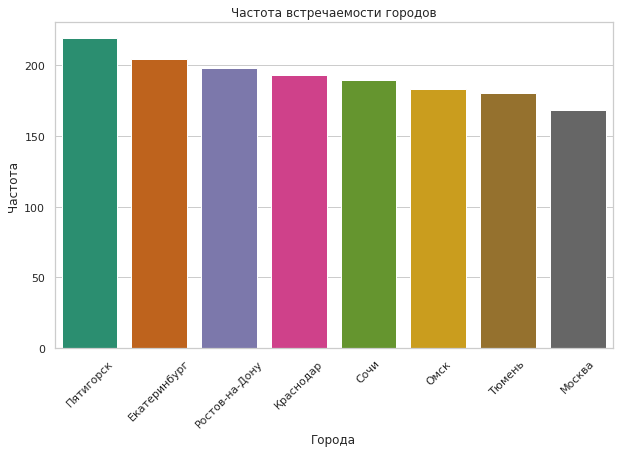

In [10]:
city_counts = users['city'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.index, y=city_counts.values, palette="Dark2")
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

В нашей выборке больше всего пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону

###### Построение графика распределения типов подписки по выборке

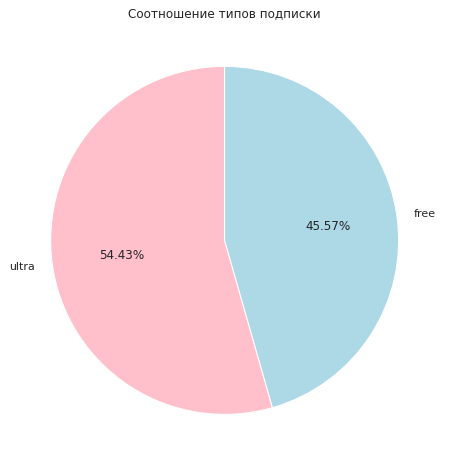

In [11]:
# Формируем параметры для графика
subscr = users['subscription_type'].value_counts()
labels = users['subscription_type'].unique()
sizes = [subscr.free, subscr.ultra]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Соотношение типов подписки')
plt.show()

Большинство пользователей имееют подписку.

###### Построение графика распределения возраста пользователей  по выборке

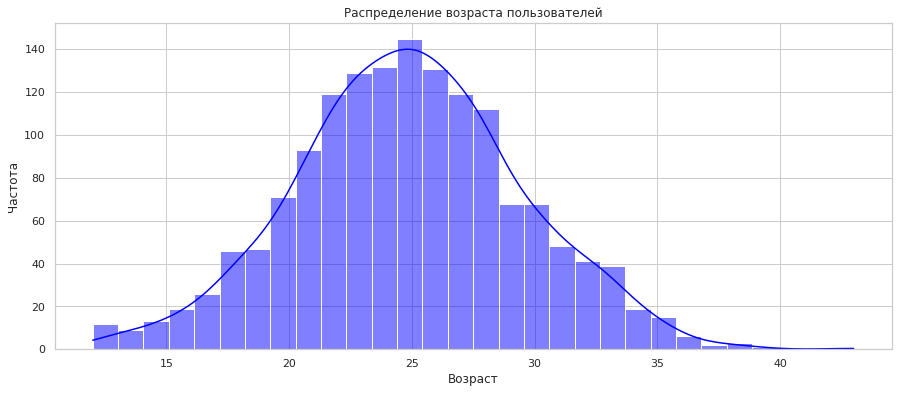

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


In [12]:
plt.figure(figsize=(15, 6))
sns.histplot(users['age'], bins=30, color='blue', kde=True)
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()
print(users['age'].describe())

Возраст пользователей имеет нормальное распределение, средний возраст около 25 лет. Минимальный 12 лет, максимальный 43.

###### Построение графика распределения дальности поездок по выборке

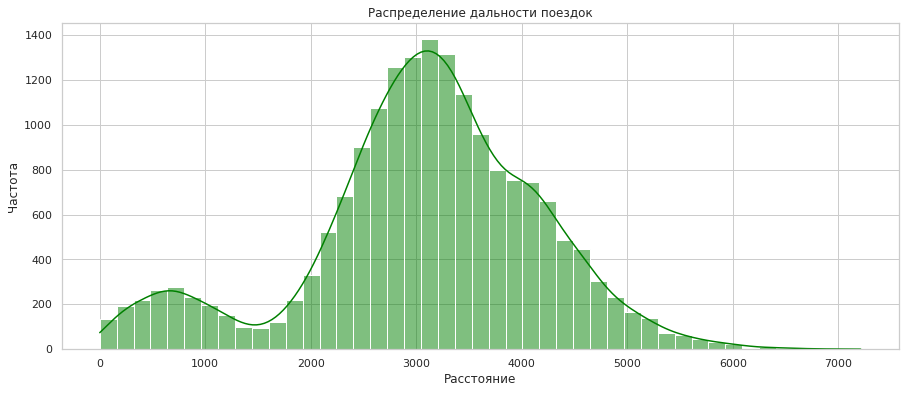

In [13]:
plt.figure(figsize=(15, 6))
sns.histplot(rides['distance'], bins=45, color='green', kde=True)
plt.title('Распределение дальности поездок')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

Назвал бы этот график двугорбым, состоящим из двух распределений, напоминающих нормальное. Пик первого горба в районе 700 метров, правый конец в районе 1400 метров. Это поезки на короткое расстояние. Пик второго горба в районе 3100 метров, правых хвост графика в районе 6000 метров. Это поездки средней и большой дальности.

###### Построение графика распределения продолжительности поездок по выборке

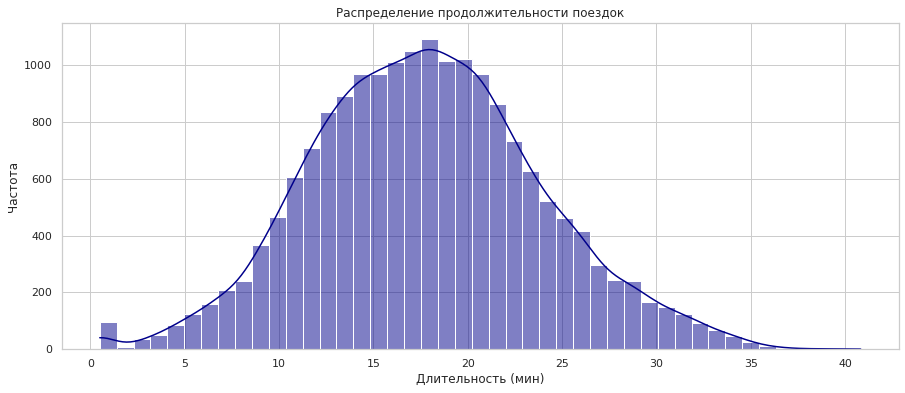

Средняя продолжительность поездки: 17.81, медианная продолжительность поездки: 18.0


In [14]:
plt.figure(figsize=(15, 6))
sns.histplot(rides['duration'], bins=45, color='darkblue', kde=True)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Длительность (мин)')
plt.ylabel('Частота')
plt.show()
print(f"Средняя продолжительность поездки: {rides['duration'].mean().round(2)}, медианная продолжительность поездки: {rides['duration'].median().round()}")

График длительности поездок напоминает нормальное распределение, с пиком около 18 минут. Так же на графике виден выделяющийся рост частоты поездок (в районе 100 поездок) длительностью около 1 минуты.

#### Шаг 4. Объединение данных

##### Объединение данных о пользователях

In [15]:
# Создаем общий Dataframe
big_data = pd.merge(users, rides, on='user_id')
print(f'В users было {users.shape[0]} строк, в rides было {rides.shape[0]} в big_data стало {big_data.shape[0]}.')
big_data = pd.merge(big_data, subscriptions, on='subscription_type')
print(f'В конечном big_data {big_data.shape[0]} строк.')

В users было 1534 строк, в rides было 18068 в big_data стало 18068.
В конечном big_data 18068 строк.


In [16]:
data_free = big_data[big_data['subscription_type'] == 'free']

In [17]:
data_ultra = big_data[big_data['subscription_type'] == 'ultra']

##### Сравнение дальности поездок в зависимости о подписки

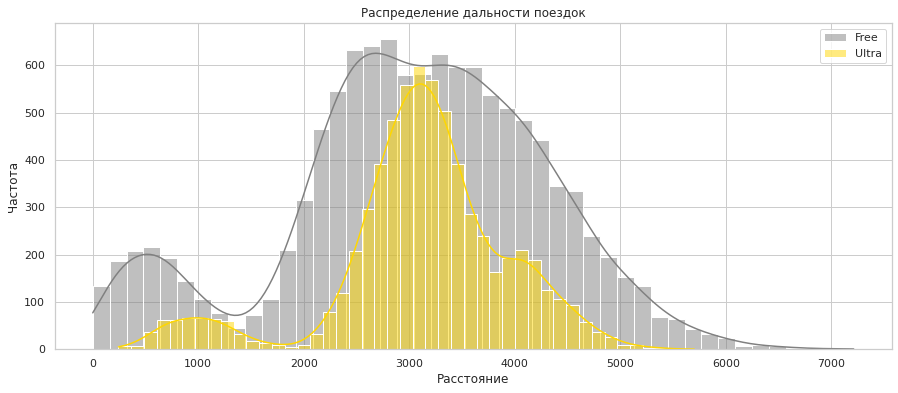

In [18]:
plt.figure(figsize=(15, 6))
sns.histplot(data_free['distance'], bins=45, color='gray', kde=True, label='Free')
sns.histplot(data_ultra['distance'], bins=45, color='gold', kde=True, label='Ultra')
plt.title('Распределение дальности поездок')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.legend()
plt.show()

В целом графики пользователей с разными подписками похожи пропорциями. Отличия заключаются в том, что разброс у пользователей без подписки шире. Пользователи без подписки чаще берут самокаты на очень короткие (до 500 метров) и дальние (свыше 5000 метров) расстояния.

##### Сравнение длительности поездок в зависимости о подписки

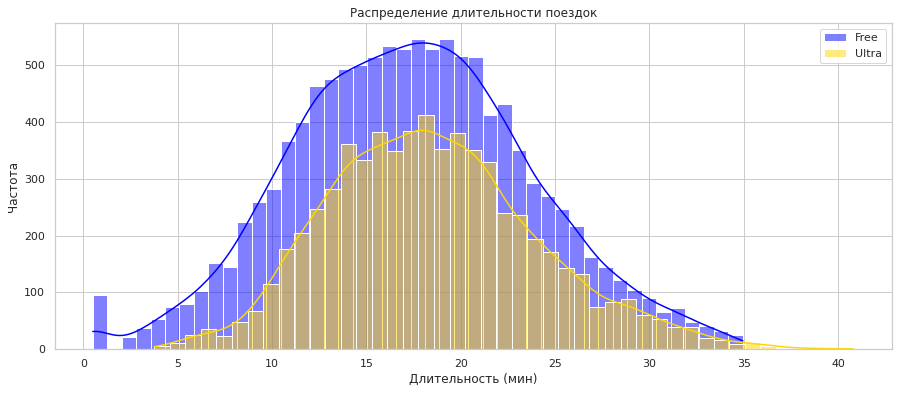

In [19]:
plt.figure(figsize=(15, 6))
sns.histplot(data_free['duration'], bins=45, color='blue', kde=True, label='Free')
sns.histplot(data_ultra['duration'], bins=45, color='gold', kde=True,  label='Ultra')
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность (мин)')
plt.ylabel('Частота')
plt.legend()
plt.show()

Графики длительности поездок пропорционально похожи. С одним явным отличием - пользователи с подпиской практически не берут самокаты на время менее 5 минут. Так же пользователи с подпиской не берут самокаты на время около одной минуты. Что говорит о том, что это опытные пользователи, которые не берут самокат на тест-драйв ради интереса.

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными:  суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [20]:
# Округляем значения в distance и duration
big_data['distance'] = big_data['distance'].round(2)
big_data['duration'] = big_data['duration'].round(2)
# Добавим суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
big_data['total_distance'] = big_data.groupby('user_id')['distance'].transform('sum')
big_data['total_rides'] = big_data.groupby('user_id')['distance'].transform('count')
big_data['total_month_time'] = big_data.groupby(['user_id', 'month'])['duration'].transform('sum')
# Расчет стоимости каждой поездки
big_data['ride_sum'] = big_data['start_ride_price'] + big_data['minute_price'] * np.ceil(big_data['duration'])

##### Создание датафрейма с помесячной выручкой, которую принёс каждый пользователь

In [21]:
# Создание сводной таблицы для получения уникальной выручки пользователя за месяц
revenue_pivot = big_data.pivot_table(index=['user_id', 'month'], values='ride_sum', aggfunc='sum')

# Добавление столбцов со стоимостью и типом подписки к сводной таблице
revenue_pivot['subscription_fee'] = big_data.groupby(['user_id', 'month'])['subscription_fee'].first().values
revenue_pivot['subscription_type'] = big_data.groupby(['user_id', 'month'])['subscription_type'].first().values

# Расчет ежемесячной выручки для каждого пользователя
revenue_pivot['month_revenue'] = revenue_pivot['ride_sum'] + revenue_pivot['subscription_fee']

# Сброс индексов 
revenue_pivot.reset_index(inplace=True)
revenue_pivot.head(10)

,user_id,month,ride_sum,subscription_fee,subscription_type,month_revenue
0,1,1,252.0,199,ultra,451.0
1,1,4,42.0,199,ultra,241.0
2,1,8,276.0,199,ultra,475.0
3,1,10,192.0,199,ultra,391.0
4,1,11,336.0,199,ultra,535.0
5,1,12,168.0,199,ultra,367.0
6,2,3,378.0,199,ultra,577.0
7,2,4,240.0,199,ultra,439.0
8,2,6,84.0,199,ultra,283.0
9,2,7,288.0,199,ultra,487.0


В датафрейм добавлены столбцы ride_sum и month_revenue, для выделение выручки от одной конкретной поездки и общей выручки пользователя за календарный месяц.

 Средняя выручка за поездку: 262.63р.
 Средняя выручка за месяц по всем пользователям: 323157.75р.


Text(0, 0.5, 'Выручка')

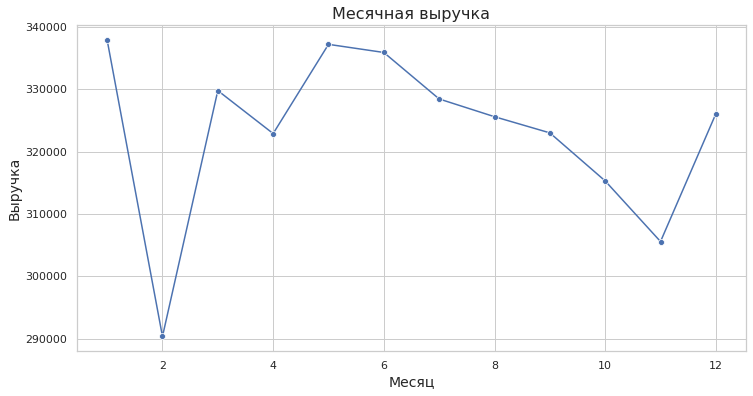

In [22]:
# Дополнительный расчет статистических показателей
print(f' Средняя выручка за поездку: {revenue_pivot.ride_sum.mean().round(2)}р.')
print(f' Средняя выручка за месяц по всем пользователям: {revenue_pivot.groupby("month")["month_revenue"].sum().mean().round(2)}р.')
monthly_revenue = revenue_pivot.groupby('month')['month_revenue'].sum().reset_index()
# Создание графика
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='month_revenue', data=monthly_revenue, marker='o');
plt.title('Месячная выручка', fontsize=16)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Выручка', fontsize=14)

#### Шаг 6. Проверка гипотез

##### Нулевая гипотеза: Средние значения продолжительности поездок пользователей с разным уровнем подписки равны.                                 Альтернативная гипотеза: Средние продолжительность поездок пользователей с подпиской больше чем у пользователей без подписки

In [23]:
# Проведение t-теста
p_value = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

# Вывод результатов
print(f'Среднее время ultra = {data_ultra["duration"].mean().round(2)}, среднее время free = {data_free["duration"].mean().round(2)}')
print(f"p-value: {p_value.pvalue}")

# Проверка статистической значимости
alpha = 0.05
if p_value.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.")
else:
    print("Не отвергаем нулевую гипотезу.")

Среднее время ultra = 18.54, среднее время free = 17.39
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.


 P-value значительно меньше общепринятого уровня значимости. На этом основании сделаем выводы о том, что можно отвергнуть нулевую гипотезу в пользу альтернативной. Пользователи с подпиской в среднем тратят больше времени на поездки.

##### Нулевая гопотеза:  Средняя дистанция пользователей с подпиской равна 3130 метров. Альтернативная гипотеза: Средняя дистанция пользователей с подпиской больше 3130 метров

In [24]:
p_value = st.ttest_1samp(data_ultra['distance'], 3130, alternative='greater')

alpha = 0.05
print(f'Расчет среднего расстояния составляет: {data_ultra["distance"].mean().round(2)} метров')
print(f"p-value: {p_value.pvalue}")

if p_value.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: среднее расстояние для пользователей с подпиской равно 3130 метров.")
else:
    print("Нет достаточных статистических доказательств для отвержения нулевой гипотезы.")

Расчет среднего расстояния составляет: 3115.45 метров
p-value: 0.9195368847849785
Нет достаточных статистических доказательств для отвержения нулевой гипотезы.


Значение p-value больше общепринятого уровня значимости. Это означает, что у нас нет достаточных статистических доказательств для отвержения нулевой гипотезы. То есть среднее время рассчитаное по данным (3115) на столько близко к 3130 метров, что мы не можем уверенно принять альтернативную гипотезу.  На основе данных нет достаточных статистических доказательств для того, чтобы утверждать, что среднее расстояние для пользователей с подпиской отличается от 3130 метров

##### Нулевая гипотеза:  Средняя выручка пользователей с разными типами подписки равна. Альтернативная гипотеза: Средная выручка пользователей с подпиской выше.

In [25]:
revenue_subscribed = revenue_pivot.loc[revenue_pivot['subscription_type'] == 'ultra', 'month_revenue']
revenue_not_subscribed = revenue_pivot.loc[revenue_pivot['subscription_type'] == 'free', 'month_revenue']

# Проведем t-тест
p_value = st.ttest_ind(revenue_subscribed, revenue_not_subscribed, equal_var=False, alternative='greater')

# Выведем результаты
print(f"Средняя выручка пользователей ultra: {revenue_pivot[revenue_pivot['subscription_type'] == 'ultra'].month_revenue.mean().round(2)}")
print(f"Средняя выручка пользователей free: {revenue_pivot[revenue_pivot['subscription_type'] == 'free'].month_revenue.mean().round(2)}.")
print(f"p-value: {p_value.pvalue}") # Было при дублировании выручек 0.999999

# Примем уровень значимости 0.05
alpha = 0.05
if p_value.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средняя месячная выручка от пользователей с подпиской выше.")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Средняя выручка пользователей ultra: 362.73
Средняя выручка пользователей free: 328.58.
p-value: 8.473077792319447e-40
Отвергаем нулевую гипотезу: Средняя месячная выручка от пользователей с подпиской выше.


Р-value близок к нулевому значению, и значительно ниже alpha. На этом основании мы отвергаем нулевую гипотезу в пользу альтернативной. Средняя месячная выручка от пользователей с подпиской выше.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Нам бы потребовался тест для зависимых выборок (scipy.stats.ttest_rel(before, after))

#### Шаг 7. Распределения

##### Подбор оптимального количества промокодов

In [ ]:
# Находим n
# задаём параметры биномиального распределения
n = np.nan
p = 0.1
target = 100
for step in range(1, 5000):
    result = st.norm(step*p, np.sqrt(step * p * (1 - p))).cdf(target)
    if result < 0.05:
        n = step
        break
        

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
 
# строим график
plt.figure(figsize=(10,5))
x = np.linspace(mu - 4*sigma, mu + 4*sigma)
y = st.norm(mu, sigma).cdf(x)
plt.plot(x, y)
plt.yticks(np.linspace(0, 1, 21))
 
# считаем вероятность хвоста слева
result = st.norm(mu, sigma).cdf(target)
print(f'При рассылке промокодов для {n} пользователей, вероятность получить менее {target} продлений равна:{result.round(2)}')
#result2 = st.norm(mu, sigma).ppf(0.05)
#print(result2)

График и расчет по формуле показывают что минимальное количество промокодов, необходимое для рассылки  - 1169 шт.
При этом количестве вероятность получение нужного результата - 95%

##### Оценка вероятности открытия  399500 уведомлений

In [ ]:
# Заданные параметры
n = 1000000  # количество рассылаемых уведомлений
p = 0.4  # вероятность открытия уведомления

# Аппроксимация биномиального распределения нормальным
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
norm_approx = st.norm(mu, sigma)

# Оценка вероятности открытия не более 399,5 тыс. пользователей
target_openings = 399500
probability = norm_approx.cdf(target_openings)

# Построение графика
plt.figure(figsize=(10,5))
x = np.linspace(mu - 4*sigma, mu + 4*sigma)
y = norm_approx.cdf(x)
plt.plot(x, y, label='Аппроксимация нормальным распределением')
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.xticks(rotation=45)
plt.yticks(np.linspace(0, 1, 21))


# Вывод результатов
print(f"Оценка вероятности открытия не более {target_openings} пользователей: {probability:.2f}")

In [ ]:
# Построение графика
plt.figure(figsize=(10,5))
x = np.linspace(mu - 4*sigma, mu + 4*sigma)
y = norm_approx.cdf(x)

# Найти точку пересечения
intersection_point = norm_approx.ppf(0.5)
intersection_probability = norm_approx.cdf(intersection_point)

# Построение графика аппроксимации
plt.plot(x, y, label='Аппроксимация нормальным распределением')

# Построение красной вертикальной линии в точке пересечения
plt.axvline(intersection_point, color='red', linestyle='--', label=f'Точка пересечения\n({intersection_point:.2f}, {intersection_probability:.2f})')

# Добавление легенды и названий осей
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')

# Установка меток на осях для более наглядного отображения
plt.xticks(rotation=45)
plt.yticks(np.linspace(0, 1, 21))

# Добавление легенды
plt.legend()

# Вывод результатов
print(f"Оценка вероятности открытия не более {target_openings} пользователей: {probability:.2f}")

# Отображение графика
plt.show()

Расчет показывает, что вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 0.15

#### Вывод

В этом проекте был выполнен анализ данных по сервису аренды самокатов. Была проанализированна вырчука по месяцам года и пользователям, сравнивались пользователи с подпиской и без подписки.

По итогу могу констатировать следущее. В целом пользователи с подпиской приносят больше выручки, чеще пользуются услугами сервиса. В целом это более лояльные сервису пользователи, увеличение их количества должно положительно сказаться на развитии сервиса. 

Основной возраст пользователей сервиса это 20 - 30 лет. Длительность большинства поездок находится в диапазоне от 10 до 25 минут. Расстояние большинства поездок находятся в диапазоне от 2 до 4,5 километров.Средняя выручка за поездку: 262.63р. Средняя выручка за месяц по всем пользователям: 323157.75р. Нет сильно выраженного фактора сезонности. Относительные просадки по выручке в феврале(290 т.р.) и ноябре(305 т.р.), в остальные выручка держится в диапазоне 320 - 340 т.р.

К качестве рекомендации было бы интересно подробнее проанализировать клиентов по возрастным группам, роду занятий и интересов для более четкого выявления целевой аудитории. И в дальнейшем привлечения людей с подходящими под ЦА характеристиками в пул клиентов сервиса.
   